# ASHRAE - Great Energy Predictor III Challenge 

![](ashrae.png)

#  <font color='Black'>Table of Contents</font>

[1. Problem Statement and Use of Machine Learning](#section1)<br>
[2. Data cleaning & Preprocesing](#section2)<br>
[3. EDA](#section3)<br>
[4. Feature Engineering](#section4)<br>
[5. Prepating Train & Test Data](#section5)<br>
[6. Modelling with various ML models](#section6)<br>

# <a id = 'section1'> 1. Problem Statement </font> </a>

 This case study is a kaggle competition conducted by ASHRAE during 2019.The Kaggle competiton could be found here - https://www.kaggle.com/c/ashrae-energy-prediction 


 Founded in 1894,  ASHRAE serves to advance the arts and sciences of heating, ventilation, air conditioning refrigeration and their allied fields. ASHRAE members represent building system design and industrial process professionals around the world.With over 54,000 members serving in 132 countries, ASHRAE supports research, standards writing, publishing and continuing education - shaping tomorrow’s built environment today. 

### 1.1 How are we utilising ML for this problem </font> </a>

In this competition, you’ll develop accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe. With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

### 1.2 About the data 

 Building meta-data -  This contains all the data about a building like Site ID, Building ID, primary use, year built, area of building, floor count.

 Training data - This contains building ID, meter type, time-stamp on which the reading was taken & the target variable meter-reading.

 Weather data - This file type contains various weather related features like air temperature, cloud coverage, dew temperature, precipitation depth per hour, sea level pressure, wind direction & wind speed along with site ID & timestamp.

###  1.3 Evaluation Metric 

 The evaluation metric used in this competition was RMSLE (Root Mean Square Logarithmic Error). You can find more about this metric here - https://www.kaggle.com/c/ashrae-energy-prediction/overview/evaluation

### Importing Libraries 

In [1]:
import os 
import random
import math 
import pickle

import gc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import datetime

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm

In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Loading Data 

In [3]:
build_meta = pd.read_csv('building_metadata.csv')
weather_tr = pd.read_csv('weather_train.csv')
#weather_te = pd.read_csv('weather_test.csv')
train_data = pd.read_csv('train.csv')
#test_data = pd.read_csv('test.csv')

In [4]:
print("Number of data points in build_meta", build_meta.shape) 
print("Number of data points in weather_tr", weather_tr.shape)
#print("Number of data points in weather_te", weather_te.shape)
print("Number of data points in train_data", train_data.shape)
#print("Number of data points in test_data", test_data.shape)

Number of data points in build_meta (1449, 6)
Number of data points in weather_tr (139773, 9)
Number of data points in train_data (20216100, 4)


In [5]:
print("The attributes of building meta data :", build_meta.columns.values)

The attributes of building meta data : ['site_id' 'building_id' 'primary_use' 'square_feet' 'year_built'
 'floor_count']


In [6]:
print("The attributes of weather data :", weather_tr.columns.values)

The attributes of weather data : ['site_id' 'timestamp' 'air_temperature' 'cloud_coverage'
 'dew_temperature' 'precip_depth_1_hr' 'sea_level_pressure'
 'wind_direction' 'wind_speed']


In [7]:
print("The attributes of train data :", train_data.columns.values)

The attributes of train data : ['building_id' 'meter' 'timestamp' 'meter_reading']


#  <a id = 'section2'> 2. Data Cleaning & Preprocessing </font> </a>

#### To fit the data in our RAM  We are considering a fraction of 2000000 data points from the total training set.

In [8]:
train_data = train_data[0:2000000]

### 2.1 Removing Null values from Weather DataFrame 

For cleaning weather DataFrame we are following this notebook https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling

In [9]:
weather_tr["cloud_coverage"] = (weather_tr["cloud_coverage"]).astype(np.float32)

In [10]:
weather_tr["sea_level_pressure"] = (weather_tr["sea_level_pressure"]).astype(np.float32)

In [11]:
weather_tr["precip_depth_1_hr"] = (weather_tr["precip_depth_1_hr"]).astype(np.float32)

In [12]:
weather_tr.dtypes

site_id                 int64
timestamp              object
air_temperature       float64
cloud_coverage        float32
dew_temperature       float64
precip_depth_1_hr     float32
sea_level_pressure    float32
wind_direction        float64
wind_speed            float64
dtype: object

In [13]:
# Full cedits to - https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling

'''This function removes null values present in the weather dataframe'''

def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

In [14]:
weather_train_df = fill_weather_dataset(weather_tr)

In [15]:
weather_train_df.isnull().sum()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

### 2.2  Checking training dataframe for zero values 

In [16]:
train_data.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

### 2.3 Checking building dataframe for zero values 

In [17]:
build_meta.isnull().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

#### Number of zero values by percentage

In [18]:
percent_missing = build_meta.isnull().sum() * 100 / len(build_meta)
print(percent_missing)

site_id         0.000000
building_id     0.000000
primary_use     0.000000
square_feet     0.000000
year_built     53.416149
floor_count    75.500345
dtype: float64


Built year & Floor count Feature have more than 50% of missing values so we won't be using them in our modelling.

In [19]:
# Credits to - https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type

'''This function adds lags feature in the weather dataframe for given window '''

def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [20]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [21]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2016-01-01 00:00:00,25.0,6.000000,20.0,-0.173913,1019.700012,0.0,0.0,25.000000,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2016-01-01 01:00:00,24.4,4.285714,21.1,-1.000000,1020.200012,70.0,1.5,24.703125,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2016-01-01 02:00:00,22.8,2.000000,21.1,0.000000,1020.200012,0.0,0.0,24.062500,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2016-01-01 03:00:00,21.1,2.000000,20.6,0.000000,1020.099976,0.0,0.0,22.765625,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2016-01-01 04:00:00,20.0,2.000000,20.0,-1.000000,1020.000000,250.0,2.6,21.296875,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477


In [22]:
weather_train_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'air_temperature_mean_lag3',
       'air_temperature_max_lag3', 'air_temperature_min_lag3',
       'air_temperature_std_lag3', 'cloud_coverage_mean_lag3',
       'cloud_coverage_max_lag3', 'cloud_coverage_min_lag3',
       'cloud_coverage_std_lag3', 'dew_temperature_mean_lag3',
       'dew_temperature_max_lag3', 'dew_temperature_min_lag3',
       'dew_temperature_std_lag3', 'precip_depth_1_hr_mean_lag3',
       'precip_depth_1_hr_max_lag3', 'precip_depth_1_hr_min_lag3',
       'precip_depth_1_hr_std_lag3', 'sea_level_pressure_mean_lag3',
       'sea_level_pressure_max_lag3', 'sea_level_pressure_min_lag3',
       'sea_level_pressure_std_lag3', 'wind_direction_mean_lag3',
       'wind_direction_max_lag3', 'wind_direction_min_lag3',
       'wind_direction_std_lag3', 'wind_speed_mean_lag3',
       'wind_speed_max_lag

In [23]:
weather_train_df.shape

(140544, 65)

In [24]:
weather_train_df.isnull().sum()

site_id                      0
timestamp                    0
air_temperature              0
cloud_coverage               0
dew_temperature              0
                            ..
wind_direction_std_lag72    16
wind_speed_mean_lag72        0
wind_speed_max_lag72         0
wind_speed_min_lag72         0
wind_speed_std_lag72        16
Length: 65, dtype: int64

### 2.4 Merging the DataFrames

In [25]:
# merge all the cleaned dataframes into one single dataframe
train_one = train_data.merge(right = build_meta, on = 'building_id', how = 'left')
xtr = train_one.merge(right = weather_train_df, on = ['site_id','timestamp'], how = 'left')

In [26]:
print("Number of data points in merged training set", xtr.shape)

Number of data points in merged training set (2000000, 72)


In [27]:
xtr.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'air_temperature_mean_lag3', 'air_temperature_max_lag3',
       'air_temperature_min_lag3', 'air_temperature_std_lag3',
       'cloud_coverage_mean_lag3', 'cloud_coverage_max_lag3',
       'cloud_coverage_min_lag3', 'cloud_coverage_std_lag3',
       'dew_temperature_mean_lag3', 'dew_temperature_max_lag3',
       'dew_temperature_min_lag3', 'dew_temperature_std_lag3',
       'precip_depth_1_hr_mean_lag3', 'precip_depth_1_hr_max_lag3',
       'precip_depth_1_hr_min_lag3', 'precip_depth_1_hr_std_lag3',
       'sea_level_pressure_mean_lag3', 'sea_level_pressure_max_lag3',
       'sea_level_pressure_min_lag3', 'sea_level_pressure_std_lag3',
       'wind_direction_mean_lag3', 'wind_direction_max_lag3',
    

###  2.5 Function to reduce Memory usage by the dataframes

In [28]:
#Full credits to -
#https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

'''This Function reduces the size of the dataset columns by selecting samller datatypes '''

def reduce_mem_usg(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [29]:
final_xtr = reduce_mem_usg(xtr)

Mem. usage decreased to 316.62 Mb (33.1% reduction)


#### Removing long streaks of zero values from site_id 0

In [29]:
final_xtr['timestamp']=pd.to_datetime(final_xtr["timestamp"],format='%Y-%m-%d %H')

In [30]:
final_xtr['date'] = final_xtr['timestamp'].dt.date

In [31]:
final_xtr['meter_reading_log1p'] = np.log1p(final_xtr['meter_reading'])

In [32]:
#full credits to - https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type

'''This function plots the meter readings of building 0 across various months of the year'''

def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    fig = px.line(train_temp_df_meter, x='date', y='meter_reading_log1p')
    fig.show()

plot_date_usage(final_xtr, meter=0, building_id=0)


Plot Summary  -  

1. From the above plot of meter reading across the year 2016 we observe a continous streak of zeros values.


2. There are continous zero values in the meter readings till May from January.


3. There are some non-zero values in the plot till May.


4. But these values too are very minute. From somewhere around mid May month we see a big jump in the meter reading. 
   Suddenly the zeros values jumps close to 130 kWh. 
   
                 
5. After this we observe a much stable meter reading compared to the previous months of January to May. 


6. From Mid-month of May till December the reading lies in the range of the 120kWh - 140kWh. 


7. Somewhere in December we see a sudden drop in the readings. The readings falls close to 100kWh for a short period of time        then it comes back in the range of 120 - 140kWh.

In [33]:
final_xtr = final_xtr.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [34]:
print("Number of data points in train set after data cleaning", final_xtr.shape)

Number of data points in train set after data cleaning (1910532, 74)


In [35]:
final_xtr[final_xtr['meter_reading'] > 40000].shape

(3629, 74)

In [36]:
final_xtr = final_xtr[final_xtr['meter_reading'] < 40000]

In [37]:
final_xtr.shape

(1906903, 74)

# <a id = 'section3'>  3. EDA </font> </a>

In [40]:
#finding the raw values of the target variable 
final_xtr.meter_reading.describe()

count    1.906903e+06
mean     4.309541e+02
std      1.560995e+03
min      0.000000e+00
25%      1.722000e+01
50%      7.326780e+01
75%      2.460000e+02
max      3.993750e+04
Name: meter_reading, dtype: float64

### 3.1 Distribution of various meter types

([<matplotlib.axis.XTick at 0x21974af14e0>,
 <a list of 4 Text xticklabel objects>)

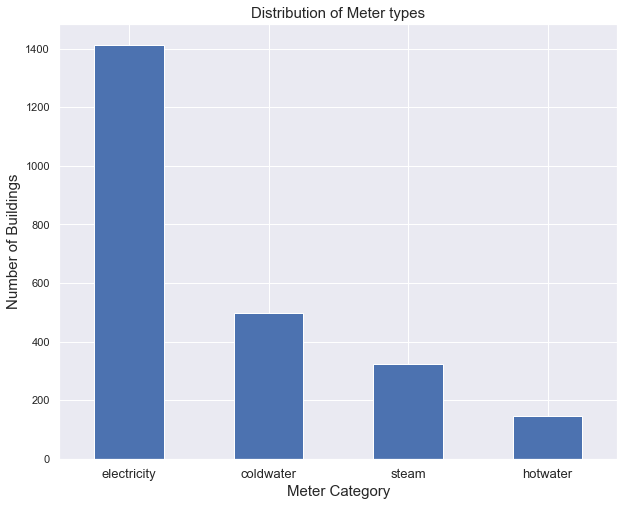

In [38]:
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 8))
ax = train_data.groupby('meter')['building_id'].nunique().plot(kind = 'bar')
ax.set_title('Distribution of Meter types', fontsize = 15)
plt.xlabel('Meter Category', fontsize = 15)
plt.ylabel('Number of Buildings', fontsize = 15)
plt.xticks(range(4), ["electricity", "coldwater", "steam", "hotwater"], rotation=0, fontsize=13) 

Plot Summary - 

1. The above plot shows number of meters from each category present in the number of buildings.


2. We observe that the electricity meter type is the most common meter type & is found in more than 1400 buildings.


3. Cold-water meter is found in lose to 500 buildings.


4. Steam meter type is being used in approximately 300 buildings.


5. Hot-water is the least used meter type which is found in less than 200 buildings.

### 3.2 Meter counts across various Building types

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text yticklabel objects>)

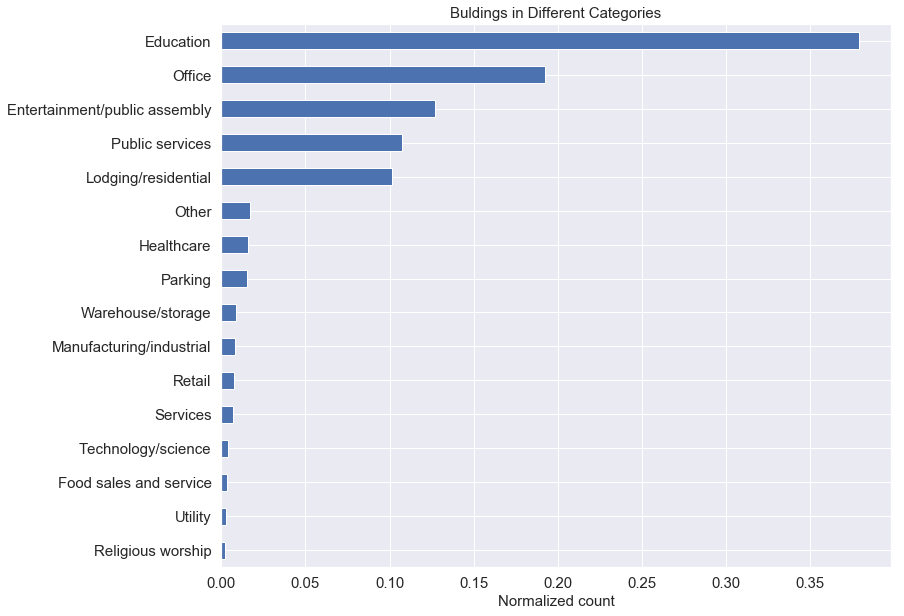

In [39]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 10))
ax = (build_meta['primary_use'].value_counts(normalize='True').sort_values(ascending=True))
ax.plot(kind = 'barh')
plt.title('Buldings in Different Categories', fontsize = 15)
plt.xlabel('Normalized count', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

Plot Summary - The plot above shows the normalized count of the buldings from each category 


1. More than 35% of the buildings are under educational categories.


2. Educational category is followed by Office category being close to 20% of the total buildings.


3. Entertainment spots & public assembly places contribute 12% - 13% of the total number of the buildings.


4. Public services building account slightly more than 10% of all buildings.


5. Lodging / Residential building type covers 10% of building totality.


6. All other building categories have a much lower contribution comprising around 1 to 2 percent.


7. Least number of buildings are found under the religious worship category.

### 3.3 Meter types found in various building categories

Text(0,0.5,'Energy Usage')

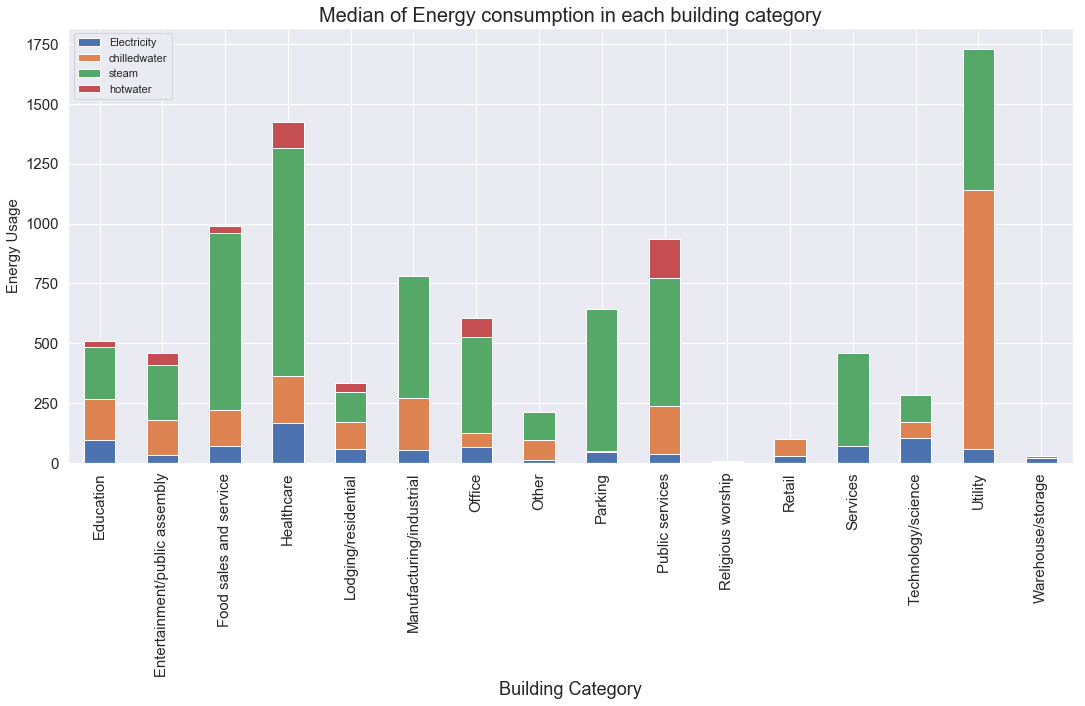

In [40]:
# reference - https://matplotlib.org/api/pyplot_api.html
ax=xtr.groupby(['primary_use', 'meter'])['meter_reading'].median().unstack().plot(stacked = True, kind = 'bar', figsize=(18,8))
ax.set_title('Median of Energy consumption in each building category', fontsize = 20)
plt.legend(labels = ['Electricity', 'chilledwater', 'steam', 'hotwater'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Building Category', fontsize = 18)
plt.ylabel('Energy Usage', fontsize = 15)

Plot Summary -  The above plot shows energy usage by different meter types in each building category 


1. From the above plot we can deduce that the electricity meter type is common in all the building categories.


2. Obviously all the building categories need electricity to run any type of device.


3. The second most common meter type is the chilled water meter type.


4. After chilled water meter type the most common meter type is the steam meter.


5. Hot water is the least found meter types.


6. Also from the plot we observe that the steam meter consumes most electricity & hence we could say its least efficient.


7. Whereas the electricity meter consumes the least energy amongst all the meter types.


8. Amongst all the building categories religious places building shows least usage whereas the utilities building have the highest usage. 


9. But chilled water meter type consumes a lot of energy in the utilities buildings.

### 3.3 Median areas of  building categories

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text yticklabel objects>)

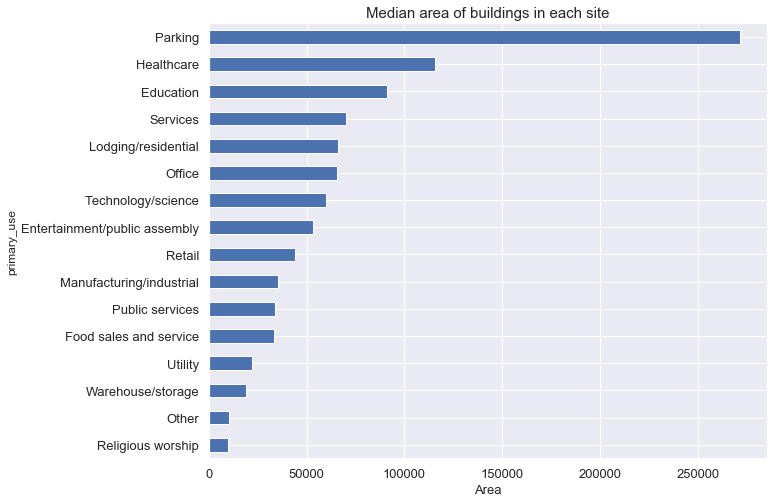

In [41]:
plt.figure(figsize=(10,8))
final_xtr.groupby('primary_use')['square_feet'].median().sort_values().plot(kind = 'barh')
plt.title('Median area of buildings in each site', fontsize = 15)
plt.xlabel('Area', fontsize = 13)
plt.xticks(fontsize=13, rotation=360)
plt.yticks(fontsize=13)

Plot Summary - The above plot shows median areas of different building categories 


1. Parking sites have the highest areas amongst all the building types which falls in the range of 250000 to 300000 square feet range.


2. This is followed by healthcare which has area slightly more than 100000 square feets.


3. Education buildings hava an area slightly less than 100000 square feets.


4. Sites of Services, lodging / residential, Office, Technology & Entertainment / Public Assembly have areas in the range of 50000 to 100000 square feets.


5. Manufacturing, Public services  & utility sites have area less than 50000 square feets.


6. Amongst all the sites religious worship places  have the least area.

### 3.3 Median Floor count of  building categories

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 <a list of 9 Text yticklabel objects>)

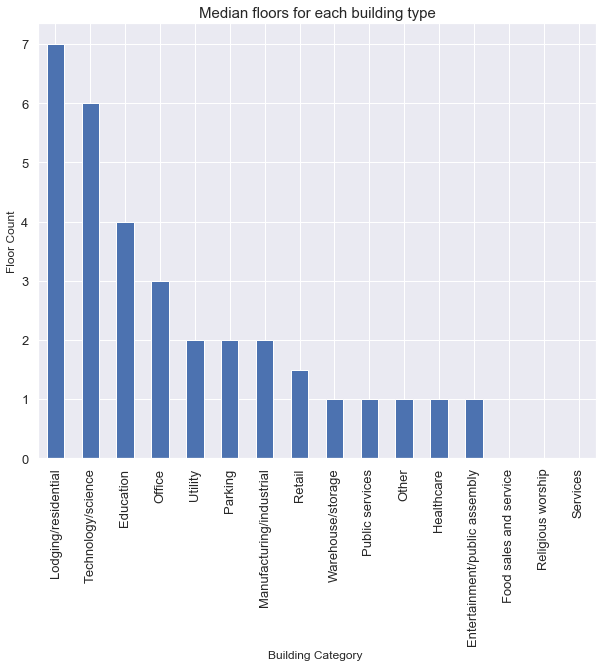

In [42]:
# Residential/Lodging are tallest
plt.figure(figsize=(10,8))
final_xtr.groupby('primary_use')['floor_count'].median().sort_values(ascending = False).plot(kind = 'bar')
plt.title('Median floors for each building type', fontsize = 15)
plt.xlabel('Building Category ')
plt.ylabel('Floor Count')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

Plot Summary -  The above plot shows the median floor count of the buildings 


1. Residential buildings have the highest floor median count which has 7 floors.


2. Technology & science buildings has a median floor count of 6.


3. Education buildings category has median count of  4 floors.


4. Office buildings have a median floor count of 3.


5. Warehouse, Public services, Others,Healthcare, Entertainment / Public Assembly has floor median count of 1.

   
6. Food sales and services, religious worship & services have only ground floors.

### 3.4 Impact of Air Temperature on Energy Consumption

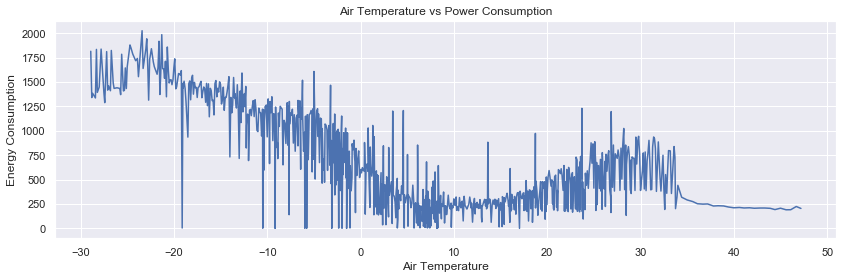

In [43]:
fig, ax = plt.subplots(figsize=(14, 4))
final_xtr.groupby('air_temperature')['meter_reading'].mean().plot()
ax.set_title('Air Temperature vs Power Consumption', fontsize = 12)
plt.xlabel('Air Temperature', fontsize = 12)
plt.ylabel('Energy Consumption', fontsize = 12)
plt.show()

Plot Summary - The above plot shows effect of energy consumption from Air temperature 


1. We observe highest energy consumption in the range of 1250 to 1750 kWh when    the air temperature range is -30 to -20 degree celsius.
   

2. From -20 to -10 degree celsius the energy consumption starts to decline &      falls in the range of 1250 to 1500 kWh.


3. We see further decrease in the energy consumption from -10 to 0 degress & it    falls in the range of 1000 kWh to 1250 kWh. 


4. The least energy consumption is seen from 10 to 20 degree celsius 0 to 250      kWh. 


5. From 20 degrees to 30 degrees the energy consumption start to rise again
   in the range of 500kWh to 750kWh.

### 3.5 Impact of Cloud coverage on Energy Consumption

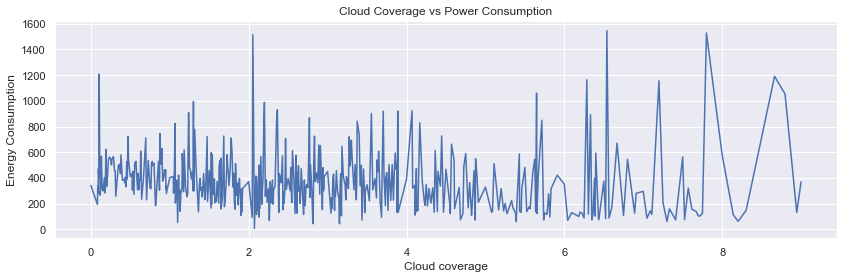

In [44]:
fig, ax = plt.subplots(figsize=(14, 4))
final_xtr.groupby('cloud_coverage')['meter_reading'].mean().plot()
ax.set_title('Cloud Coverage vs Power Consumption', fontsize = 12)
plt.xlabel('Cloud coverage', fontsize = 12)
plt.ylabel('Energy Consumption', fontsize = 12)
plt.show()

 Plot Summary - The above plot shows effect of energy consumption from cloud                   coverage 
 
 1. From the above plot we see that energy consumption remains more or less in     the same range. 
 
 
 2. From this we can conclude that the cloud coverage does not has any direct       impact on the energy consumption.
 
 
 3. We observe some higher values in the plot but it could possibly due to         present of some outlier.

### 3.5 Impact of Dew Temperature on Energy Consumption

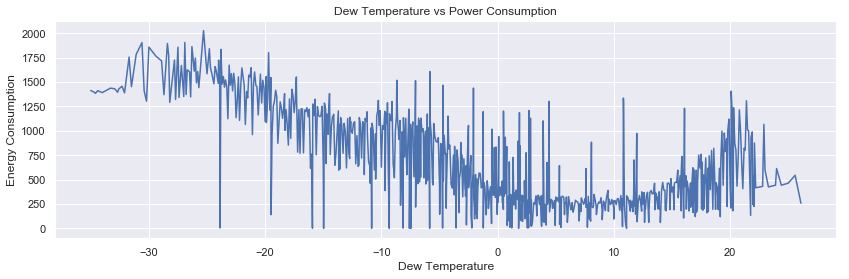

In [44]:
fig, ax = plt.subplots(figsize=(14, 4))
final_xtr.groupby('dew_temperature')['meter_reading'].mean().plot()
ax.set_title('Dew Temperature vs Power Consumption', fontsize = 12)
plt.xlabel('Dew Temperature', fontsize = 12)
plt.ylabel('Energy Consumption', fontsize = 12)
plt.show()

Plot Summary - The above plot shows effect of energy consumption from Air temperature 

1. The plot for Dew temperature vs Energy Consumption has the same pattern as the air_temperature.


2. So we can conclude that the pattern for dew temperature is same as air_temperature.


3. May be both of these features are correlated to each other & hence we are observing similar patterns in them.

### 3.6 Plotting Distribution of Target Feature

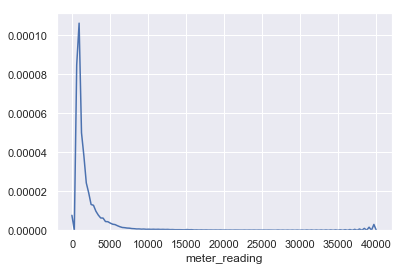

In [45]:
sns.distplot(final_xtr["meter_reading"],hist=False)

 Meter reading appears to be heavily skewed with some outliers 

#### Plotting for log normal distribution 

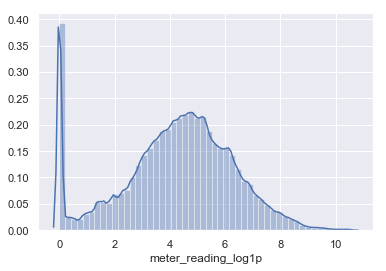

In [46]:
sns.distplot(final_xtr['meter_reading_log1p'])

 After converting to log normal distribution this plot seems much more workable now.

In [47]:
for i in range(0,100,10):
    var = final_xtr["meter_reading"].values
    var = np.sort(var, axis = None)
    print(" The {} percentile value of meter reading is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("The 100 percentile value of meter reading is", var[-1])

 The 0 percentile value of meter reading is 0.0
 The 10 percentile value of meter reading is 1.524999976158142
 The 20 percentile value of meter reading is 12.970000267028809
 The 30 percentile value of meter reading is 28.25
 The 40 percentile value of meter reading is 49.97999954223633
 The 50 percentile value of meter reading is 81.83329772949219
 The 60 percentile value of meter reading is 128.9510040283203
 The 70 percentile value of meter reading is 206.22900390625
 The 80 percentile value of meter reading is 376.6549987792969
 The 90 percentile value of meter reading is 809.780029296875
The 100 percentile value of meter reading is 39987.5


 Looks like we have some few high values near the 100th percentile.

In [48]:
for i in range(90,100):
    var = final_xtr["meter_reading"].values
    var = np.sort(var, axis = None)
    print(" The {} percentile value of meter reading is {}".format(i, var[int(len(var)*(float(i)/100))]))
print("The 100 percentile value of meter reading is", var[-1])

 The 90 percentile value of meter reading is 809.780029296875
 The 91 percentile value of meter reading is 902.2109985351562
 The 92 percentile value of meter reading is 1007.2999877929688
 The 93 percentile value of meter reading is 1150.43994140625
 The 94 percentile value of meter reading is 1337.239990234375
 The 95 percentile value of meter reading is 1579.969970703125
 The 96 percentile value of meter reading is 1930.9200439453125
 The 97 percentile value of meter reading is 2472.199951171875
 The 98 percentile value of meter reading is 3343.070068359375
 The 99 percentile value of meter reading is 5207.7001953125
The 100 percentile value of meter reading is 39987.5


 Even going from 90th to 100 percentile the values seem reasonable till 99th percentile.

In [49]:
for i in np.arange(0.0, 1.0, 0.1):
    var = final_xtr["meter_reading"].values
    var = np.sort(var, axis = None)
    print(" The {} percentile value of meter reading is {}".format(99+i, var[int(len(var)*(float(99+i)/100))]))
print("The 100 percentile value of meter reading is", var[-1])

 The 99.0 percentile value of meter reading is 5207.7001953125
 The 99.1 percentile value of meter reading is 5529.56005859375
 The 99.2 percentile value of meter reading is 5882.81005859375
 The 99.3 percentile value of meter reading is 6373.759765625
 The 99.4 percentile value of meter reading is 7091.33984375
 The 99.5 percentile value of meter reading is 8064.27978515625
 The 99.6 percentile value of meter reading is 9632.8095703125
 The 99.7 percentile value of meter reading is 11718.7998046875
 The 99.8 percentile value of meter reading is 14724.2001953125
 The 99.9 percentile value of meter reading is 21634.400390625
The 100 percentile value of meter reading is 39987.5


 The 99.8th percentile value to 100th percentile values seems to large & potentially could be outliers.So we will be removing these extreme values.

In [38]:
final_xtr.shape

(1906903, 74)

In [39]:
# code source - https://nbviewer.jupyter.org/github/stevensmiley1989/ASHRAE-for-ML/blob/master/Part-2-And.ipynb
final_xtr=final_xtr.drop((final_xtr.loc[final_xtr['meter_reading'] > 1.5e+04])['meter_reading'].index)

In [40]:
final_xtr.shape

(1901988, 74)

### 3.7 Steps Followed for EDA :-

1. We started with finding the range & details about the target variable likecount, mean, min value, max value etc.


2. We plotted for the distribution of meter types & found the number of buildings for each meter type.


3. Then we found the number of building in different in each catefory like educational buildings,
   offices etc.
    
    
4. Then we plotted to find which type of meter consumes what amount of electricity in each building type.


5. After this we plotted the areas of the building acccording to their primary use.


6. Then we plotted the median areas of the buildings & their floor count.


7. Then we plotted the impact of weather related features like air temperature, dew temperature,
   cloud coverage etc on the energy consumption.
    
    
8. Then we changed the distribution of target variable to log normal to reduce the skewness of the target variable.


9. Then we found the percentile values of the target variables to remove outliers from the target radings.

### 3.8 Inference from EDA

1. The electricity type meter is found in the most of the buildings followed by cold water, steam & hot water.



2. The top five buildings types with most number of meters are :- 
   i. Educational Buildings
   
   ii. Office Buildings 
   
   iii. Entertainment / Public Assembly 
   
   iv. Public Services
   
   v. Lodging / Residential 



3. The steam meter type is the most inefficient meter type as it consumes most energy comapared to other meter types.



4. After the steam type meter chilled water meter type is the least efficient meter type. Electricity meter type is the most efficient amongst all.



5. Considering all the weather related features the energy consumption is lower when the temperatures are optimal. 



6. Too low Air temperature causes very higher energy consumption.Cloud coverage does not has much impact on the energy consumption.



7. The target variable meter reading is skewed so we convert it to log normal to reduce the skewness of the data.



8. By finding the percentile values of the meter readings we further remove some outliers from the data.

### 3.9 Assumptions regarding the data

1. The target variable i.e meter reading is skewed so we took log of meter reading varaible.


2. Floor count & built year features have a vey high percentage of missing values so we are not using them for any analysis or modelling.


3. Meter readings with value of more than 40000kWh seems exceptionally large so we dropped all the datapoints which had values more than 40000kWh. 

# <a id = 'section4'> 4. Feature Engineering </font> </a>

#### We have covered some part feature engineering in the precprocessing section where we introduced the weather lag features.These variable adds to a total of 56 new variables.

### 4.1 Five New Features from Stripping timestamps into its components 

 We convert the given time stamps into year, month, weeekday, day & hour

In [41]:
final_xtr["timestamp"] = pd.to_datetime(final_xtr["timestamp"])
final_xtr["year"] = final_xtr["timestamp"].dt.year
final_xtr["month"] = final_xtr["timestamp"].dt.month
final_xtr["weekend"] = final_xtr["timestamp"].dt.weekday
final_xtr["day"] = final_xtr["timestamp"].dt.day
final_xtr["hour"] = final_xtr["timestamp"].dt.hour
print ('Shape of Training : ', final_xtr.shape)
final_xtr.head()

Shape of Training :  (1901988, 79)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72,date,meter_reading_log1p,year,month,weekend,day,hour
103,105,0,2016-01-01,23.303600,1,Education,50623,NaN,5.0,3.800781,...,3.099609,3.099609,NaN,2016-01-01,3.190624,2016,1,4,1,0
104,106,0,2016-01-01,0.374600,1,Education,5374,NaN,4.0,3.800781,...,3.099609,3.099609,NaN,2016-01-01,0.318163,2016,1,4,1,0
105,106,3,2016-01-01,0.000000,1,Education,5374,NaN,4.0,3.800781,...,3.099609,3.099609,NaN,2016-01-01,0.000000,2016,1,4,1,0
106,107,0,2016-01-01,175.184006,1,Education,97532,2005.0,10.0,3.800781,...,3.099609,3.099609,NaN,2016-01-01,5.171529,2016,1,4,1,0
107,108,0,2016-01-01,91.265297,1,Education,81580,1913.0,5.0,3.800781,...,3.099609,3.099609,NaN,2016-01-01,4.524668,2016,1,4,1,0


### 4.2 One New Feature from Log Transforming Areas of the Building 

Areas of the building have a very wide range so normalizing them & then using it might work better for  the model.

In [42]:
final_xtr['log_square_feet'] = np.log(final_xtr['square_feet'])

We would have used the age feature of a building as well but as this feature has more than 50% missing values it is not suitable to impute such a large chunk of missing values.

### 4.3 Plotting Correlation Heatmap

### Correlation Heatmaps of Newly generated Weather Related Features

In [41]:
df_corr2 = pd.concat([pd.DataFrame(weather_train_df, columns = ['wind_speed_std_lag3',
       'air_temperature_mean_lag72', 'air_temperature_max_lag72',
       'air_temperature_min_lag72', 'air_temperature_std_lag72',
       'cloud_coverage_mean_lag72', 'cloud_coverage_max_lag72',
       'cloud_coverage_min_lag72', 'cloud_coverage_std_lag72',
       'dew_temperature_mean_lag72', 'dew_temperature_max_lag72',]),
        pd.DataFrame(final_xtr['meter_reading_log1p']).reset_index(drop = True)],axis = 1)

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_corr2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Plot Summary  -  The above plot shows the correlation between the various features we have engineered that are related to weather 

All the above features are for 72 hours of time frame  - 


1.  The air temperature mean lag, max-lag & min lag are indicating high correaltion with a score of 0.97.


2.  The air temperature mean lag also has high correlation with dew temperature mean & max lag of 0.85 and 0.83


3. Cloud coverage mean, max & std too have higher correlation amongst each other with a values of 0.76, 0.74 & 0.68.


4. Dew temperature mean, max too have high correlation amongst each other with a value of 0.95 for both.


5. So from the above plot we can deduce that we would be using only one feature amongst the features which have high correlation scores with each other.

In [38]:
df_corr3 = pd.concat([pd.DataFrame(weather_train_df, columns = ['precip_depth_1_hr_mean_lag72', 'precip_depth_1_hr_max_lag72',
       'precip_depth_1_hr_min_lag72', 'precip_depth_1_hr_std_lag72',
       'sea_level_pressure_mean_lag72', 'sea_level_pressure_max_lag72',
       'sea_level_pressure_min_lag72', 'sea_level_pressure_std_lag72',
       'wind_direction_mean_lag72', 'wind_direction_max_lag72']),
        pd.DataFrame(final_xtr['meter_reading_log1p']).reset_index(drop = True)],axis = 1)

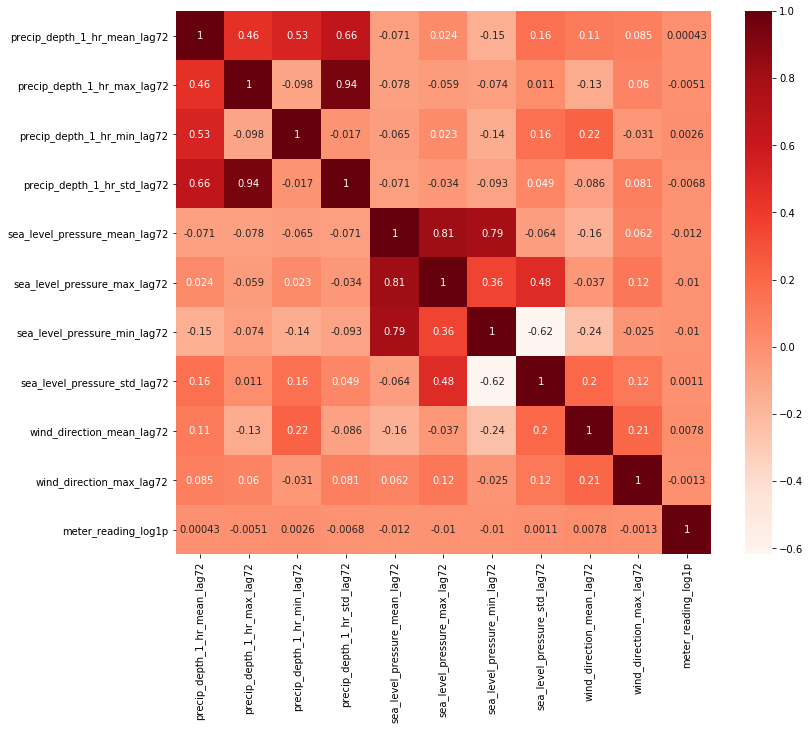

In [39]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_corr3.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Plot Summary  -  The above plot shows the correlation between the various features we have engineered that are related to weather 

All the above features are for 72 hours of time frame  - 


1.  The precipitation depth max lag, min lag & std lag are indicating high correaltion with a score of 0.46, 0.53 & 0.66 respectively.


2.  The precipitation depth max lag & std lag also have high correlation with value of 0.94.


3. Sea level pressure mean, min & std too have higher correlation amongst each other with a values of 0.81 & 0.79.


4. So from the above plot we can deduce that we would be using only one feature amongst the features which have high correlation scores with each other.

In [40]:
df_corr4 = pd.concat([pd.DataFrame(weather_train_df, columns = ['wind_direction_min_lag72', 'wind_direction_std_lag72',
       'wind_speed_mean_lag72', 'wind_speed_max_lag72', 'wind_speed_min_lag72',
       'wind_speed_std_lag72']),
        pd.DataFrame(final_xtr['meter_reading_log1p']).reset_index(drop = True)],axis = 1)

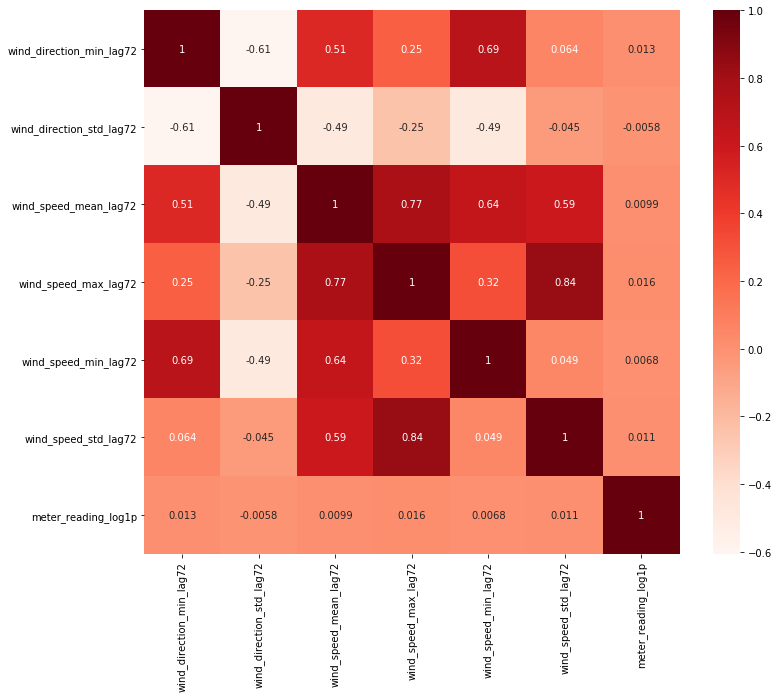

In [41]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_corr4.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Plot Summary  -  The above plot shows the correlation between the various features we have engineered that are related to weather 

All the above features are for 72 hours of time frame  - 


This plot also shows similar patters as we have seen from other previous plots where the min, mean max & std features amongst the same variable show high correlation so we should be using only one of the features from them.

### Correlation Heatmap of newly generated timestamp features & log transformed features

In [42]:
df_corr5 = pd.DataFrame(final_xtr, columns = ['year', 'month', 'weekend'
                                                           'day', 'hour', 'log_square_feet', 'meter_reading_log1p'])

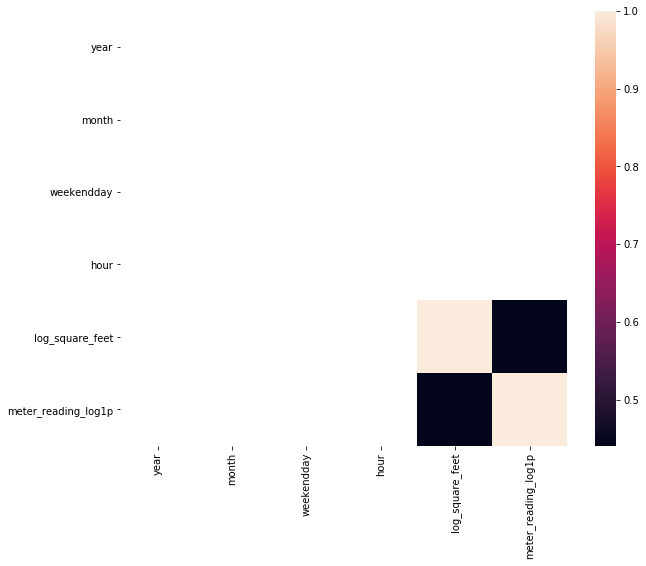

In [43]:
#Using Pearson Correlation
plt.figure(figsize=(10,8))
cor = df_corr5.corr()
sns.heatmap(cor)
plt.show()

Plot Summary  -  The above plot shows the correlation between the various features we have engineered that are related to building features :-


1. Engineered Features related to buildings show much lesser correlation to other features.


2. Month features shows zero correlation with other features.


3. Hour feature show zero correlation with other features.


4. Only the log of building area & meter reading show higher correlation than the rest of the features but it is still close to 0.4 so maybe we can use them for our modelling.

### Correlation Heatmap of Originally provided Features

In [44]:
df_corr6 = pd.concat([pd.DataFrame(final_xtr, columns = ['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built'
                                                         ]),
        pd.DataFrame(weather_train_df, columns = ['timestamp', 'air_temperature', 'cloud_coverage',
                                                 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
                                                 'wind_direction', 'wind_speed']),
        pd.DataFrame(final_xtr, columns = ['meter']),
        pd.DataFrame(final_xtr['meter_reading_log1p']).reset_index(drop = True)],axis = 1)

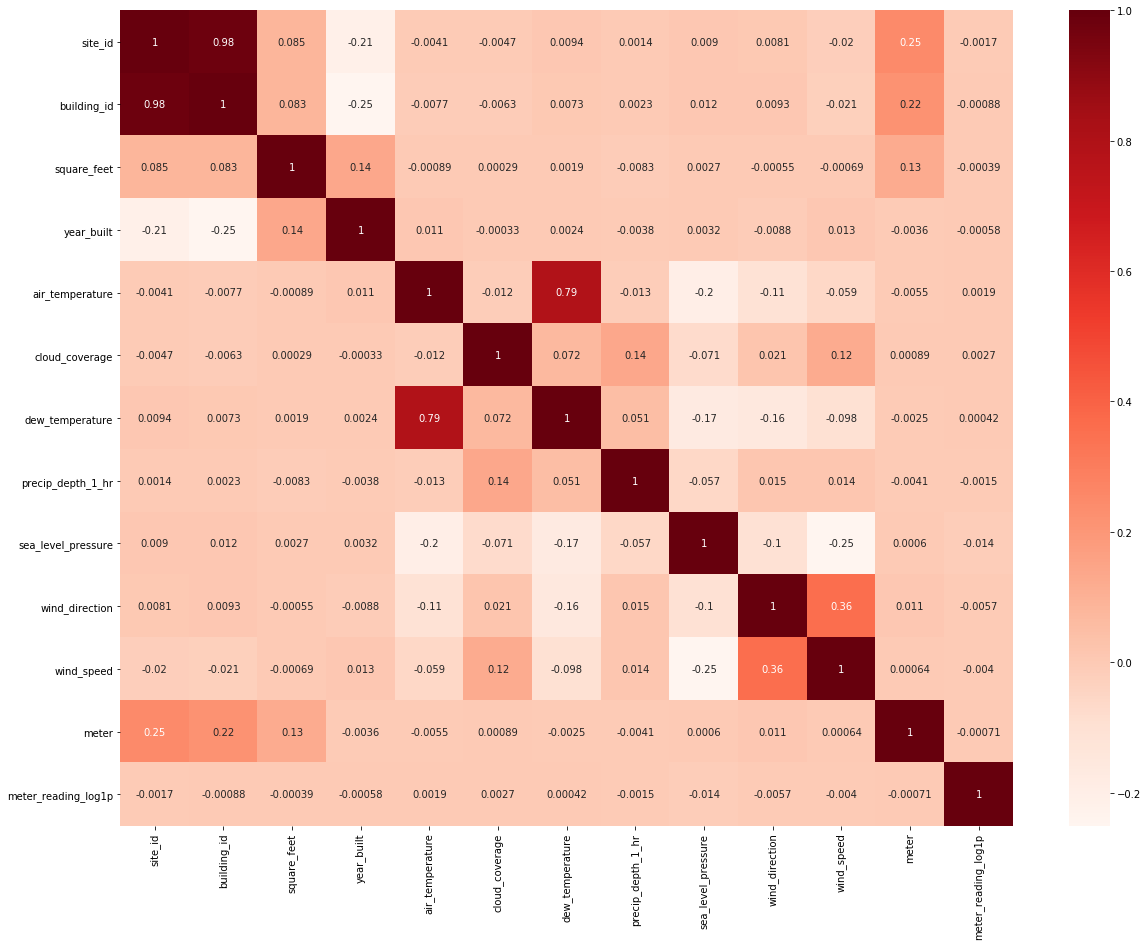

In [45]:
#Using Pearson Correlation
plt.figure(figsize=(20,15))
cor = df_corr6.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Plot Summary  -  The above plot shows the correlation between the various features that were originally present in the dataset   :-


1. Site ID & building ID are indicating very high correlation with each other with a score of 0.98.


2. Site ID & meter type also show some correlation with a value of 0.24. 


3. Air temperature & dew temperature has high correlation with each other with a score of 0.79.


4. Wind directionn & wind speed show some correlation with each other with a value of 0.36.


5. Wind Speed & cloud coverage also have some correlation with a score of 0.12.


6. After observing the above plot we will be using features which are less correlated with each other.

### 4.4 Steps followed for Feature Engineering :-

1. We considered that there would be a lag in the weather related features which would affect the current temperature. So we used all the weather related features & fond the 3 hours lag & 72 hours lag of the same. This contributed to a total of 56 new features.


2. We broke timestamp into its componenets & obtainewd 5 new features from it.


3. We took log of the building area as the areas of the building were widely spread across various values. THis would help us in greatly normalising these values. 


4. Then we found the correlation amongst all the newly engineered featues & the originally provided features in the dataset.


5. We plotted various heatmaps to show the correlation betweena all the newly generated & the original features.


6. If two features showed high correlation with each other we removed one amongst them. 

### 4.5 Inferences from Feature Engineering : -

1. The weather engineered data had features which mincluded mean, max, min, std values of the same features.These features showed high correlation with each other so we just used one of them in further modelling.


2. The temperature feature of different types e.g air temperature & dew temperature also show high correlation with each other.


3. The features generated from timestamps show very little to no correlation with the target variable & each other.


4. The features provided in the original dataset show higher correlation amongst the following features - 

    i) Site ID & Building ID

    ii) Air Temperature & Dew Temperature



# <a id = 'section1'> 5. Preparing Train & Test data for Modelling </font> </a>

### 5.1 Dropping columns which have too many missing values & high correlation

In [43]:
# Dropping columna with high missing values & which are not so useful
final_xtr.drop(columns=["timestamp","year_built","floor_count","date"], inplace=True)
final_xtr.reset_index(drop = True, inplace = True)

In [44]:
# Dropping all the engineered weather features with high correlation
final_xtr.drop(columns=['air_temperature_max_lag72', 'air_temperature_min_lag72', 
        'air_temperature_std_lag72', 'cloud_coverage_std_lag72',
        'cloud_coverage_max_lag72', 'cloud_coverage_min_lag72', 
       'dew_temperature_mean_lag72', 'dew_temperature_max_lag72',
       'dew_temperature_std_lag72', 'precip_depth_1_hr_max_lag72',
       'precip_depth_1_hr_min_lag72', 'precip_depth_1_hr_std_lag72',
       'sea_level_pressure_max_lag72', 'sea_level_pressure_min_lag72',
       'wind_direction_min_lag72', 'wind_direction_std_lag72',
       'wind_speed_mean_lag72', 'air_temperature_max_lag3',
        'air_temperature_min_lag3', 'air_temperature_std_lag3', 
        'cloud_coverage_std_lag3', 'cloud_coverage_max_lag3', 
        'cloud_coverage_min_lag3', 'dew_temperature_mean_lag3', 
        'dew_temperature_max_lag3','dew_temperature_std_lag3',
        'precip_depth_1_hr_max_lag3','precip_depth_1_hr_min_lag3', 
        'precip_depth_1_hr_std_lag3','sea_level_pressure_max_lag3',
        'sea_level_pressure_min_lag3','wind_direction_min_lag3', 
        'wind_direction_std_lag3','wind_speed_mean_lag3' ], inplace=True)
final_xtr.reset_index(drop = True, inplace = True)

### 5.2  Label encoding Primary use Feature

In [45]:
# Label Encoding primary_use Feature 

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(final_xtr['primary_use'])

final_xtr['primary_use'] = pd.Series(le.transform(final_xtr['primary_use']))

In [46]:
final_xtr = reduce_mem_usg(final_xtr)

Mem. usage decreased to 143.30 Mb (39.2% reduction)


In [47]:
final_xtr.shape

(1901988, 42)

In [48]:
final_xtr.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'air_temperature_mean_lag3', 'cloud_coverage_mean_lag3',
       'dew_temperature_min_lag3', 'precip_depth_1_hr_mean_lag3',
       'sea_level_pressure_mean_lag3', 'sea_level_pressure_std_lag3',
       'wind_direction_mean_lag3', 'wind_direction_max_lag3',
       'wind_speed_max_lag3', 'wind_speed_min_lag3', 'wind_speed_std_lag3',
       'air_temperature_mean_lag72', 'cloud_coverage_mean_lag72',
       'dew_temperature_min_lag72', 'precip_depth_1_hr_mean_lag72',
       'sea_level_pressure_mean_lag72', 'sea_level_pressure_std_lag72',
       'wind_direction_mean_lag72', 'wind_direction_max_lag72',
       'wind_speed_max_lag72', 'wind_speed_min_lag72', 'wind_speed_std_lag72',
       'meter_reading_log1p', 'year', 'month', 'weekend', 'day', 'hour',
      

In [49]:
X = final_xtr

### 5.3 Splitting Train Data into Train & Test Data 

#### The dataset has all the points sorted by date. So we will be preserving the temporal nature of the data & will be  dividing the training set into 70% split for training & 30% split for testing.

In [50]:
X_train_size = int(len(X) * 0.70)
X_train, X_test = X[0:X_train_size], X[X_train_size:len(X)]

In [51]:
print(X_train.shape)
print(X_test.shape)

(1331391, 42)
(570597, 42)


In [52]:
y = final_xtr['meter_reading_log1p']

In [53]:
y_train_size = int(len(y) * 0.70)
y_train, y_test = y[0:y_train_size], y[y_train_size:len(y)]

In [54]:
print(y_train.shape)
print(y_test.shape)

(1331391,)
(570597,)


In [55]:
type(y_train)

pandas.core.series.Series

In [56]:
X_train = X_train.fillna(0)

In [57]:
X_test = X_test.fillna(0)

In [58]:
x_train = X_train.drop(columns=['meter_reading', 'meter_reading_log1p'])
x_test = X_test.drop(columns=['meter_reading', 'meter_reading_log1p'])

In [59]:
print(x_train.shape)
print(x_test.shape)

(1331391, 40)
(570597, 40)


In [60]:
type(y_test)

pandas.core.series.Series

In [61]:
yte = y_test

In [62]:
type(yte)

pandas.core.series.Series

#### Changing  y_test from time series dataframe to normal numpy array 

In [63]:
y_test = y_test.to_frame()

In [64]:
type(y_test)

pandas.core.frame.DataFrame

In [65]:
y_test = y_test.values

In [66]:
type(y_test)

numpy.ndarray

### 5.4 Evaluation Metrics

In [67]:
'''This is a scorer function that will give a RMSLE score to our predictions '''

def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

# <a id = 'section1'> 6. Modelling with various ML models </font> </a>

### 6.1 Ridge Regressor 

### Baseline Ridge Model

In [66]:
ridge_model = Ridge(solver = "lsqr", fit_intercept=False)
ridge_model.fit(x_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='lsqr', tol=0.001)

In [67]:
preds = np.expm1(ridge_model.predict(x_test))
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(ridge_model.predict(x_train))))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , preds),'\n')

Train RMSLE =  2.010195380114417
Test RMSLE =  1.9425835571023635 



#### With Baseline Ridge model we got an RMSE of 1.99 & 1.93 respectively 

### Hyperparamter tuning

In [68]:
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV
parameters = {'alpha':[0.001,0.01,0.1,1,10,100,1000,10000],
              'fit_intercept' : [False],
              'solver' : ['lsqr']}

gs_ridge = GridSearchCV(estimator = Ridge(),
                        param_grid = parameters,
                        cv = 3, 
                        scoring = 'neg_mean_squared_error',
                        verbose = 10,
                        return_train_score = True,
                        n_jobs = 8)
gs_ridge.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   11.6s
[Parallel(n_jobs=8)]: Done  12 out of  24 | elapsed:   12.1s remaining:   12.1s
[Parallel(n_jobs=8)]: Done  15 out of  24 | elapsed:   12.3s remaining:    7.4s
[Parallel(n_jobs=8)]: Done  18 out of  24 | elapsed:   16.2s remaining:    5.4s
[Parallel(n_jobs=8)]: Done  21 out of  24 | elapsed:   16.6s remaining:    2.4s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:   16.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
                         'fit_intercept': [False], 'solver': ['lsqr']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=10)

In [69]:
print("Best Estimator ",gs_ridge.best_estimator_)

Best Estimator  Ridge(alpha=10000, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='lsqr', tol=0.001)


#### Re-training model with Hyperparameters

In [70]:
ridge_model = Ridge(solver = "lsqr", fit_intercept=False,alpha = 10000)
ridge_model.fit(x_train, y_train)

Ridge(alpha=10000, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='lsqr', tol=0.001)

In [71]:
preds = np.expm1(ridge_model.predict(x_test))
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(ridge_model.predict(x_train))))
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , preds),'\n')

Train RMSLE =  2.01019538011444
Test RMSLE =  1.9425835571774137 



#### The Train & Test RMSLE are almost same even with the tuned hyperparameters

### 6.2 Linear Regression Model

### Baseline Linear Regression Model

In [72]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression(fit_intercept=False, copy_X=True)  
regressor.fit(x_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [73]:
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(regressor.predict(x_train))))

Train RMSLE =  1.9063233366453975


In [74]:
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , np.expm1(regressor.predict(x_test))))

Test RMSLE =  1.8749439725633266


#### For Baseline Linear Regression Model the Train RMSLE is 1.89 & Test RMSLE is 1.86

### HyperParameter Tuned Linear Regression Model

In [75]:
regressor = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=8)  
regressor.fit(x_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=True)

In [76]:
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(regressor.predict(x_train))))

Train RMSLE =  1.9063233366454237


In [77]:
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , np.expm1(regressor.predict(x_test))))

Test RMSLE =  1.87494397518205


#### The Train & Test RMSLE are same for even the Hyperparameter Tuned model being 1.89 & 1.86 respectivrly.

### 6.3 LBGM Model

### Baseline LGBM Model

In [78]:
import lightgbm as lgbm
from sklearn.model_selection import KFold

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "max_depth": 5, 
    "num_leaves": 600,
    "learning_rate": 0.01,
    "reg_lambda": 2,
    "metric": "rmse",
}

In [79]:
# noting down categorical features - will be used in modeling
categorical_feature = ['building_id','meter','site_id','primary_use', 'hour', 'day', 'month']

In [80]:
#reference - analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/

features = x_train
target = y_train

kf = KFold(n_splits=3)
models = []
for xtr_index,xte_index in kf.split(features):
    xtr_features = features.loc[xtr_index]
    xtr_target = target.loc[xtr_index]
    
    xte_features = features.loc[xte_index]
    xte_target = target.loc[xte_index]
    
    d_training = lgbm.Dataset(xtr_features, label=xtr_target,categorical_feature=categorical_feature, free_raw_data=False)
    d_test = lgbm.Dataset(xte_features, label=xte_target,categorical_feature=categorical_feature, free_raw_data=False)
    
    model = lgbm.train(params, train_set=d_training, num_boost_round=2000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del xtr_features, xtr_target, xte_features, xte_target, d_training, d_test
    gc.collect()

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.86008	valid_1's rmse: 1.81721
[50]	training's rmse: 1.62599	valid_1's rmse: 1.59156
[75]	training's rmse: 1.4559	valid_1's rmse: 1.42953
[100]	training's rmse: 1.326	valid_1's rmse: 1.3071
[125]	training's rmse: 1.22481	valid_1's rmse: 1.20964
[150]	training's rmse: 1.14427	valid_1's rmse: 1.13297
[175]	training's rmse: 1.08495	valid_1's rmse: 1.07902
[200]	training's rmse: 1.03752	valid_1's rmse: 1.03845
[225]	training's rmse: 0.997335	valid_1's rmse: 1.00906
[250]	training's rmse: 0.963054	valid_1's rmse: 0.982595
[275]	training's rmse: 0.931738	valid_1's rmse: 0.961228
[300]	training's rmse: 0.904767	valid_1's rmse: 0.943984
[325]	training's rmse: 0.8825	valid_1's rmse: 0.930882
[350]	training's rmse: 0.861976	valid_1's rmse: 0.920548
[375]	training's rmse: 0.844077	valid_1's rmse: 0.911803
[400]	training's rmse: 0.825713	valid_1's rmse: 0.903374
[425]	training's rmse: 0.811755	valid_1's rmse: 0.896

[25]	training's rmse: 1.80672	valid_1's rmse: 1.94286
[50]	training's rmse: 1.57055	valid_1's rmse: 1.73317
[75]	training's rmse: 1.39225	valid_1's rmse: 1.58017
[100]	training's rmse: 1.25956	valid_1's rmse: 1.47024
[125]	training's rmse: 1.15789	valid_1's rmse: 1.38933
[150]	training's rmse: 1.07091	valid_1's rmse: 1.32272
[175]	training's rmse: 1.0015	valid_1's rmse: 1.27152
[200]	training's rmse: 0.947578	valid_1's rmse: 1.23388
[225]	training's rmse: 0.907327	valid_1's rmse: 1.20639
[250]	training's rmse: 0.874465	valid_1's rmse: 1.18473
[275]	training's rmse: 0.849547	valid_1's rmse: 1.16896
[300]	training's rmse: 0.827959	valid_1's rmse: 1.15659
[325]	training's rmse: 0.809911	valid_1's rmse: 1.14618
[350]	training's rmse: 0.794429	valid_1's rmse: 1.13783
[375]	training's rmse: 0.778632	valid_1's rmse: 1.12984
[400]	training's rmse: 0.762915	valid_1's rmse: 1.12196
[425]	training's rmse: 0.749324	valid_1's rmse: 1.11511
[450]	training's rmse: 0.736586	valid_1's rmse: 1.10863
[47

In [81]:
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(model.predict(x_train))))

Train RMSLE =  0.7446448798294047


In [82]:
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , np.expm1(model.predict(x_test))))

Test RMSLE =  0.911259437223761


#### The Train & Test RMSLE values have improved significantly compared to other models when we used LBGM. The Train RMSLE is 0.74 & the Test RMSLE is 0.90 respectively.

### Hyperparameter Tuned LGBM Model 

In [83]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 800,
    "learning_rate": 0.03,
    "feature_fraction": 0.8,
    "reg_lambda": 5, 
    "metric": "rmse",
}

In [85]:
#reference - analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/

features = x_train
target = y_train

kf = KFold(n_splits=3)
models = []
for xtr_index,xte_index in kf.split(features):
    xtr_features = features.loc[xtr_index]
    xtr_target = target.loc[xtr_index]
    
    xte_features = features.loc[xte_index]
    xte_target = target.loc[xte_index]
    
    d_training = lgbm.Dataset(xtr_features, label=xtr_target,categorical_feature=categorical_feature, free_raw_data=False)
    d_test = lgbm.Dataset(xte_features, label=xte_target,categorical_feature=categorical_feature, free_raw_data=False)
    
    model = lgbm.train(params, train_set=d_training, num_boost_round=2000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del xtr_features, xtr_target, xte_features, xte_target, d_training, d_test
    gc.collect()

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.18443	valid_1's rmse: 1.28831
[50]	training's rmse: 0.736975	valid_1's rmse: 0.98651
[75]	training's rmse: 0.55401	valid_1's rmse: 0.90935
[100]	training's rmse: 0.453086	valid_1's rmse: 0.87539
[125]	training's rmse: 0.399283	valid_1's rmse: 0.862314
[150]	training's rmse: 0.367293	valid_1's rmse: 0.856833
[175]	training's rmse: 0.344331	valid_1's rmse: 0.853434
[200]	training's rmse: 0.326033	valid_1's rmse: 0.85219
[225]	training's rmse: 0.312266	valid_1's rmse: 0.85174
[250]	training's rmse: 0.300695	valid_1's rmse: 0.851923
Early stopping, best iteration is:
[217]	training's rmse: 0.317134	valid_1's rmse: 0.851483
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.19023	valid_1's rmse: 1.20226
[50]	training's rmse: 0.744625	valid_1's rmse: 0.821328
[75]	training's rmse: 0.562769	valid_1's rmse: 0.691272
[100]	training's rmse: 0.461624	valid_1's rmse: 0.632719
[125

In [86]:
print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(model.predict(x_train))))

Train RMSLE =  0.6110801658001193


In [87]:
print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , np.expm1(model.predict(x_test))))

Test RMSLE =  0.8442427909513902


#### The Train & Test RMSLE for HyperParameter Tuned LBGM Model have improved further from what we obtained for baseline model. Now the Train RMSLE is 0.60 & the Test RMSLE is 0.84.

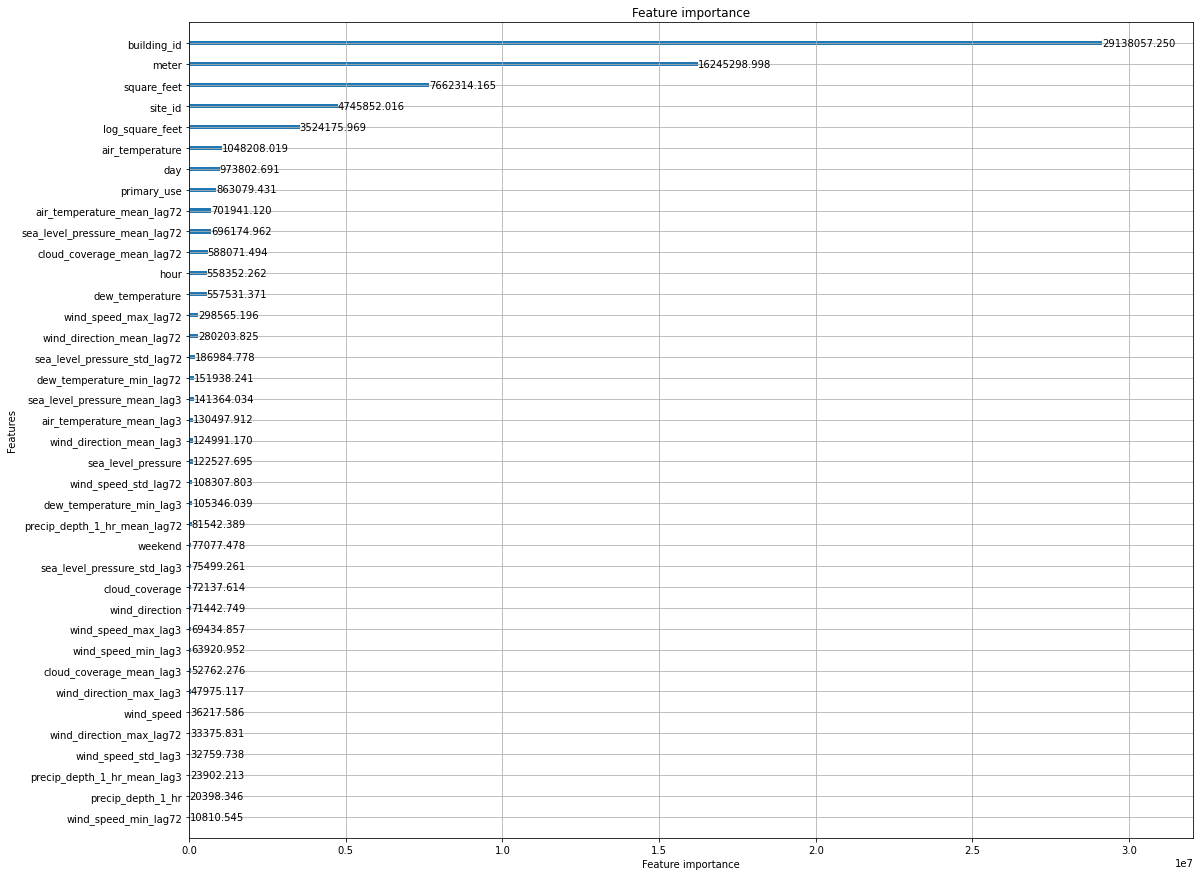

In [88]:
plt.rcParams['figure.figsize'] = (18,15)
lgbm.plot_importance(models[0], importance_type='gain')
plt.show()

By using feature importance attribute of the LBGM Model we get which feature contributed the most for the output.

The top 10 features that contributed the most for predictions are as follows - 

i) Building ID 

ii) Meter type 

iii) Area 

iv) Log of Area

v) Site ID

vi) Air Temperature 

vii) Day

Viii) Primary use

ix) sea level pressure mean lag 72

x) air temperature mean lag 72

## Ensembling models 

#### Performing Sampling with replacement on Training Data with sample size of 10000 

 Considering a Total Dataset of 1000000 points

In [68]:
D = final_xtr[0:1000000]

Splitting into 80% Train set & 20% Test Set

In [69]:
D_train_size = int(len(D) * 0.80)
D_train, D_test = D[0:D_train_size], D[D_train_size:len(D)]

Splitting D_train into 50% as D! & 50% as D2

In [70]:
D1_size = int(len(D_train) * 0.50)
D1, D2 = D_train[0:D1_size], D_train[D1_size:len(D_train)]

In [71]:
D1y = D1['meter_reading_log1p']

In [72]:
D2y = D2['meter_reading_log1p']

In [73]:
Dtest_y = D_test['meter_reading_log1p']

In [74]:
D1 = D1.drop(columns=['meter_reading', 'meter_reading_log1p'])

In [75]:
D2 = D2.drop(columns=['meter_reading', 'meter_reading_log1p'])

In [76]:
D_test = D_test.drop(columns=['meter_reading', 'meter_reading_log1p'])

In [77]:
print(D1.shape)
print(D2.shape)
print(D_test.shape)

(400000, 40)
(400000, 40)
(200000, 40)


#### Creating 1000 samples from D1 with each sample having a size of 10000 

In [99]:
from sklearn.utils import resample
array_x=[]
array_y=[]
for i in range(1000):
    x, y = resample(D1, D1y, random_state=i, n_samples = 10000)
    array_x.append(x)
    array_y.append(y)

#### Training 1000 Base learners with LGBM 

In [100]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 800,
    "learning_rate": 0.03,
    "feature_fraction": 0.8,
    "reg_lambda": 5, 
    "metric": "rmse",
}

#### Fitting 1000 samples & making predicitons on D2 as well as Test set 

In [101]:
D2_pred_df=[]
test_pred_df=[]

'''This function fits data & makes predictions then saves it in a DataFrame '''

def fit_pred(x, y, D2=D2, test_data=D_test, model=lgbm.LGBMRegressor(**params)):
    
        model = model.fit(x, y)
        D2_pred = model.predict(D2)
        test_pred = model.predict(D_test)
        D2_pred_df_1 = pd.DataFrame((D2_pred))
        test_pred_df_1 = pd.DataFrame((test_pred))
        D2_pred_df.append(D2_pred_df_1)
        test_pred_df.append(test_pred_df_1)

In [102]:
for i in range(1000):
    fit_pred(array_x[i], array_y[i], D2=D2, test_data=D_test, model=lgbm.LGBMRegressor(**params))

#### Concatenating all the predictions to form a DataFrame of Predicted Values

In [103]:
D2_pred = pd.DataFrame(D2_pred_df[0])
for i in range(999):
    D2_pred = pd.concat([D2_pred, D2_pred_df[i+1]], axis=1)

In [104]:
test_pred = pd.DataFrame(test_pred_df[0])
for i in range(999):
    test_pred = pd.concat([test_pred, test_pred_df[i+1]], axis=1)

In [105]:
D2_pred

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,5.406890,4.676831,5.194169,4.178576,5.545815,5.493564,4.559661,5.562041,4.831146,5.211310,...,4.893570,5.250194,4.974121,5.332544,5.533834,4.843594,4.967505,5.290789,4.991265,4.695826
1,4.789692,4.799530,4.467926,5.300593,4.569659,5.432114,4.781309,4.931889,4.780574,4.591454,...,4.548010,4.918019,4.729093,4.871251,4.681666,5.066974,4.810571,4.859555,5.157564,4.671045
2,4.366646,4.786084,4.297739,4.771034,4.803522,4.605854,4.791783,4.592001,4.594080,4.493253,...,4.239320,4.468863,4.803478,4.672406,4.530058,4.887118,4.832490,4.776520,4.679661,4.584151
3,3.912403,2.837564,3.468420,3.410372,3.306435,4.115559,4.554656,3.099567,4.619218,4.277430,...,3.920322,3.755373,3.822495,3.966327,3.630068,3.427063,4.176191,3.102986,4.470023,3.550705
4,3.759165,3.158892,3.839723,4.016388,3.893071,3.527043,3.826708,4.172214,4.024904,4.402679,...,3.235085,4.334998,4.043826,3.725020,4.055716,3.909643,3.953403,3.974847,4.037254,4.191863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,4.336449,4.273035,4.203988,3.684921,4.288318,2.678922,4.991395,4.652082,4.425072,4.734588,...,4.009313,5.144730,5.336997,4.931485,4.371347,3.756637,4.671143,4.127221,3.896071,3.163067
399996,3.466616,3.355224,3.605666,3.328009,3.488745,2.698223,3.405883,3.007074,3.661641,3.246319,...,3.487070,3.755997,3.687489,3.162192,3.359804,3.454168,3.530466,3.157016,3.630160,3.783548
399997,4.418525,4.028820,5.265522,4.571856,4.867911,4.212261,4.766486,4.687352,5.174721,5.387937,...,4.168133,5.630346,5.211793,4.965116,4.851971,4.385410,5.000381,4.493340,3.978167,3.714197
399998,4.500630,4.454337,4.424156,4.661215,4.532431,4.414233,4.635461,4.205366,4.802977,4.623285,...,4.318945,4.264591,4.212317,4.104954,4.518453,4.197425,4.352279,4.520133,4.493985,4.274006


In [106]:
test_pred

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,4.727845,5.417161,5.854926,4.808374,5.633997,4.573354,5.949672,4.612934,4.716130,4.897125,...,4.981907,5.132680,5.896355,5.424908,5.254892,5.355361,5.691735,4.721754,4.454271,5.443764
1,7.474527,6.343790,7.470690,6.784343,7.410874,6.546529,6.073743,6.022096,6.705705,5.941748,...,6.227260,6.778938,7.154992,7.613619,6.959066,6.890251,7.610331,6.293382,6.712299,5.921689
2,4.270240,4.499316,4.768082,4.624256,4.652767,4.620062,4.365222,4.495624,4.959059,4.905536,...,4.376218,4.615318,4.346806,4.373204,4.650491,4.437957,4.577650,4.624518,4.294511,4.786368
3,2.682829,2.866852,3.356389,3.968579,3.397535,3.370532,2.627758,3.213573,3.818444,2.425537,...,2.877457,3.144647,2.669209,2.583436,3.938599,3.800186,3.187400,3.147807,2.922814,4.221638
4,4.211944,4.723949,5.590540,5.137603,6.332336,4.992555,4.851891,4.199922,4.829161,6.316487,...,4.058975,5.677038,5.143606,4.948030,4.536964,5.365379,4.903311,5.516043,3.854869,5.419966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,5.983210,6.720848,6.438583,6.371096,6.635252,6.991361,7.067873,6.190016,7.078602,6.806992,...,6.822481,7.214806,6.471556,6.631453,5.651428,6.494923,6.418945,6.294427,7.165361,6.545907
199996,2.247749,3.880316,2.612840,4.073130,4.865105,4.022435,4.453422,4.437582,2.872044,5.410846,...,3.827830,3.145103,3.577875,3.865959,5.109585,3.496965,2.017558,4.282209,5.052475,4.213477
199997,7.450871,7.577063,7.124444,7.055494,7.471737,7.629081,6.521905,7.323249,7.462433,7.789647,...,7.375754,7.578001,7.336177,8.013768,7.768514,7.387824,6.922495,7.596874,7.537573,6.981371
199998,4.118501,5.105231,4.762551,5.368031,5.911019,6.327426,6.613160,6.128956,5.361384,6.310145,...,4.290434,5.619237,5.005396,4.663025,4.150372,5.282868,6.252950,5.181225,4.047866,4.311078


#### Removing Headers from the Predictions Dataset

In [107]:
D2_pred.to_csv('D2_pred.csv', header=False, index=False)
D2_pred = pd.read_csv('D2_pred.csv', header=None)
D2_pred = D2_pred.values

In [108]:
test_pred.to_csv('test_pred.csv', header=False, index=False)
test_pred = pd.read_csv('test_pred.csv', header=None)
test_pred = test_pred.values

#### Fitting on the Predictions DataFrame

In [109]:
lgbm_model = lgbm.LGBMRegressor(**params)
lgbm_model.fit(D2_pred, D2y)

LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.03, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=800,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=5, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

#### Making Predictions on the Test Set 

In [110]:
preds = np.expm1(lgbm_model.predict(test_pred))

#### Converting D2y & Dtest_y to numpy array for getting Final scores

In [90]:
D2y = D2y.to_frame()

In [91]:
D2y = D2y.values

In [92]:
type(D2y)

numpy.ndarray

In [93]:
type(Dtest_y)

pandas.core.series.Series

In [94]:
Dtest_y = Dtest_y.to_frame()

In [95]:
Dtest_y = Dtest_y.values

In [96]:
type(Dtest_y)

numpy.ndarray

In [111]:
print('Train RMSLE = ',rmsle_score(np.expm1(D2y) , np.expm1(lgbm_model.predict(D2_pred))))

Train RMSLE =  0.48506846502713324


In [112]:
print('Test RMSLE = ',rmsle_score(np.expm1(Dtest_y) , preds),'\n')

Test RMSLE =  0.8357900830166635 



We tried Ensembling on the dataset with 1000 Base Learners & we got a result 
slightly better than the individual model So instead of using such complex model it would be better to use the simple individual LGBM Model.

So we would consider HyperParameter Tuned LGBM as our final model.

## Deep Learning Models

In [7]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


In [4]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('C:/Users/hims1/Ashrae'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/hims1/Ashrae\1_eda.ipynb
C:/Users/hims1/Ashrae\Ashrae - Great Energy Predictor III.ipynb
C:/Users/hims1/Ashrae\Ashrae Final  GCP v2 Final - Great Energy Predictor III.ipynb
C:/Users/hims1/Ashrae\Ashrae Final  GCP v2- Great Energy Predictor III.ipynb
C:/Users/hims1/Ashrae\Ashrae Final - Great Energy Predictor III.ipynb
C:/Users/hims1/Ashrae\ashrae.png
C:/Users/hims1/Ashrae\building_metadata.csv
C:/Users/hims1/Ashrae\D2_pred.csv
C:/Users/hims1/Ashrae\final_xte.csv
C:/Users/hims1/Ashrae\sample_submission.csv
C:/Users/hims1/Ashrae\test.csv
C:/Users/hims1/Ashrae\test_pred.csv
C:/Users/hims1/Ashrae\train.csv
C:/Users/hims1/Ashrae\Untitled.ipynb
C:/Users/hims1/Ashrae\Untitled1.ipynb
C:/Users/hims1/Ashrae\Untitled2.ipynb
C:/Users/hims1/Ashrae\weather_test.csv
C:/Users/hims1/Ashrae\weather_train.csv
C:/Users/hims1/Ashrae\X_test.csv
C:/Users/hims1/Ashrae\X_train.csv
C:/Users/hims1/Ashrae\.ipynb_checkpoints\1_eda-checkpoint.ipynb
C:/Users/hims1/Ashrae\.ipynb_checkpoints\Ashrae - Great En

In [46]:
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from keras.losses import mean_squared_error as mse_loss


from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#### Preparing Train & Test Set for fitting into the Model

In [32]:
x_train = pd.read_csv("X_train.csv")

In [33]:
x_test = pd.read_csv("C:/Users/hims1/Ashrae/X_test.csv")

In [34]:
x_train.drop(x_train.columns[x_train.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [36]:
x_test.drop(x_test.columns[x_test.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [38]:
target = np.log1p(x_train["meter_reading"])

In [39]:
target_test = np.log1p(x_test["meter_reading"])

In [41]:
x_train = x_train.drop(columns=['meter_reading', 'meter_reading_log1p'])

In [42]:
x_test = x_test.drop(columns=['meter_reading', 'meter_reading_log1p'])

In [43]:
x_train.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,...,wind_direction_max_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72,year,month,weekend,day,hour,log_square_feet
0,105,0,1,0,50623,3.8,0.0,2.4,0.0,1021.0,...,240.0,3.1,3.1,0.0,2016,1,4,1,0,10.836
1,106,0,1,0,5374,3.8,0.0,2.4,0.0,1021.0,...,240.0,3.1,3.1,0.0,2016,1,4,1,0,8.586
2,106,3,1,0,5374,3.8,0.0,2.4,0.0,1021.0,...,240.0,3.1,3.1,0.0,2016,1,4,1,0,8.586
3,107,0,1,0,97532,3.8,0.0,2.4,0.0,1021.0,...,240.0,3.1,3.1,0.0,2016,1,4,1,0,11.484
4,108,0,1,0,81580,3.8,0.0,2.4,0.0,1021.0,...,240.0,3.1,3.1,0.0,2016,1,4,1,0,11.310


### Architecture 1 :-  Sequential Model with 2 Dense Layers

In [135]:
Batch_Size = 64
Learning_rate = 0.0003
Epochs = 30

In [136]:
model_reg = Sequential()
model_reg.add(Dense(256, kernel_initializer='glorot_normal', activation='relu', input_dim=40))
model_reg.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
model_reg.add(Dense(1))

In [141]:
adam = optimizers.adam(lr=Learning_rate)
model_reg.compile(loss='mse', optimizer=adam)

In [142]:
model_reg.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 256)               10496     
_________________________________________________________________
dense_46 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 129       
Total params: 43,521
Trainable params: 43,521
Non-trainable params: 0
_________________________________________________________________


In [143]:
history = model_reg.fit(x_train, target,
                    epochs=Epochs,
                    verbose=1, 
                    validation_data=(x_test, target_test),
                    )

Train on 1331391 samples, validate on 570597 samples
Epoch 1/30
1331391/1331391 [==============================] - 133s 100us/step - loss: 4.1136 - val_loss: 4.3162
Epoch 2/30
1331391/1331391 [==============================] - 132s 99us/step - loss: 3.6761 - val_loss: 3.5274
Epoch 3/30
1331391/1331391 [==============================] - 133s 100us/step - loss: 3.5903 - val_loss: 3.4059
Epoch 4/30
1331391/1331391 [==============================] - 129s 97us/step - loss: 3.5544 - val_loss: 3.3114
Epoch 5/30
1331391/1331391 [==============================] - 127s 95us/step - loss: 3.5271 - val_loss: 3.3373
Epoch 6/30
1331391/1331391 [==============================] - 123s 92us/step - loss: 3.4890 - val_loss: 3.3125
Epoch 7/30
1331391/1331391 [==============================] - 123s 93us/step - loss: 3.4544 - val_loss: 3.2510
Epoch 8/30
1331391/1331391 [==============================] - 124s 93us/step - loss: 3.4302 - val_loss: 3.4877
Epoch 9/30
1331391/1331391 [=============================

In [144]:
''"This is a scorer function for calaculating RMSLE"''

def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [160]:
print('Train RMSLE = ',rmsle_score(np.expm1(target) , np.expm1(model_reg.predict(x_train))))

Train RMSLE =  1.6063063324663285


In [145]:
preds = np.expm1(model_reg.predict(x_test,batch_size = 64,verbose = 1))
print('RMSLE of Test set is ',rmsle_score(np.expm1(target_test).values , preds))

570597/570597 [==============================] - 9s 15us/step
RMSLE of Test set is  1.6111324618429952


### Architecture 2  :-  Sequential Model with 6 Dense Layers 

In [148]:
tr_input = x_train.shape[1] 
te_input = x_test.shape[1]

In [153]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten, BatchNormalization


# create the  network
model = Sequential()
model.add(Dense(512, activation='relu',   input_dim=tr_input))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 512)               20992     
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
dense_61 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
dense_62 (Dense)             (None, 128)             

In [157]:
model.fit(x_train, target,  batch_size = 4168,
          epochs = 60, verbose = 1, 
          validation_data=(x_test, target_test))

Train on 1331391 samples, validate on 570597 samples
Epoch 1/60
1331391/1331391 [==============================] - 10s 7us/step - loss: 6.2917 - val_loss: 3.8786TA: 1s 
Epoch 2/60
1331391/1331391 [==============================] - 8s 6us/step - loss: 4.3589 - val_loss: 3.6000
Epoch 3/60
1331391/1331391 [==============================] - 8s 6us/step - loss: 4.0567 - val_loss: 3.6465
Epoch 4/60
1331391/1331391 [==============================] - 8s 6us/step - loss: 3.9569 - val_loss: 3.6188
Epoch 5/60
1331391/1331391 [==============================] - 8s 6us/step - loss: 3.9008 - val_loss: 3.5783
Epoch 6/60
1331391/1331391 [==============================] - 8s 6us/step - loss: 3.8707 - val_loss: 3.6389
Epoch 7/60
1331391/1331391 [==============================] - 8s 6us/step - loss: 3.8365 - val_loss: 3.5075
Epoch 8/60
1331391/1331391 [==============================] - 8s 6us/step - loss: 3.8112 - val_loss: 3.4478
Epoch 9/60
1331391/1331391 [==============================] - 8s 6us/step -

In [161]:
print('Train RMSLE = ',rmsle_score(np.expm1(target) , np.expm1(model.predict(x_train))))

Train RMSLE =  1.893043048351508


In [158]:
preds = np.expm1(model.predict(x_test,batch_size = 4168,verbose = 1))
print('RMSLE of Test set is ',rmsle_score(np.expm1(target_test).values , preds))

570597/570597 [==============================] - 1s 2us/step
RMSLE of Test set is  1.8631497456782922


In [164]:
from prettytable import PrettyTable
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
x.field_names = [ "Model", "Type", "Train RMSLE", "Test RMSLE"]
x.add_row(["Ridge Regressor", "Baseline", "1.99", "1.93"])
x.add_row(["Ridge Regressor", "Hyperparameter Tuned", "1.97", "1.94"])
x.add_row(["Linear Regression", "Baseline", "1.89", "1.86"])
x.add_row(["Linear Regression", "HyperParamter Tuned", "1.89", "1.86"])
x.add_row(["Sequential model", "6 Layers", "1.89", "1.86"])
x.add_row(["Sequential model", "2 Layers", "1.60", "1.61"])
x.add_row(["LGBM", "BaseLine", "0.74", "0.90"])
x.add_row(["LGBM", "HyperParameter Tuned", "0.60", "0.84"])
x.add_row(["LGBM - Ensembled", "HyperParameter Tuned", "0.48", "0.83"])
print(x)

+-------------------+----------------------+-------------+------------+
|       Model       |         Type         | Train RMSLE | Test RMSLE |
+-------------------+----------------------+-------------+------------+
|  Ridge Regressor  |       Baseline       |     1.99    |    1.93    |
|  Ridge Regressor  | Hyperparameter Tuned |     1.97    |    1.94    |
| Linear Regression |       Baseline       |     1.89    |    1.86    |
| Linear Regression | HyperParamter Tuned  |     1.89    |    1.86    |
|  Sequential model |       6 Layers       |     1.89    |    1.86    |
|  Sequential model |       2 Layers       |     1.60    |    1.61    |
|        LGBM       |       BaseLine       |     0.74    |    0.90    |
|        LGBM       | HyperParameter Tuned |     0.60    |    0.84    |
|  LGBM - Ensembled | HyperParameter Tuned |     0.48    |    0.83    |
+-------------------+----------------------+-------------+------------+


### Summary :-

#### Steps Followed for the Case Study :- 

1. We started with understanding the problem statement of the case study & made a summary of how the we will be utilising ML for this problem. 


2. We then performed Data cleaning / Preprocessing & reduced the memory usage of the dataframes.


3. After that we performed EDA on several building features & weather related features.


4. Then we performed Feature engineering  & obtained features by splitting the timestamps. We also got many weather related features.


5. We then removed the features which had high correlation with each other & plotted heatmaps for the same.


6. Then we did final preparation on the train & test data so as to fit them into various ML models. 


7. Then we used various ML models like Linear Regressiion, BaseLine Ridge Model, LGBM Model on the data.


8. After this we performed Ensembling & tried a few Neural network architecture based on Deep Learning. We then compared the results that we obtained using various techniques. 

#### Comparing Results obtained from various Models :-

1. The first model that we tried was a simple Ridge Regressor which gave us a score of 1.99 as Train RMSLE & 1.93 as the Test RMSLE.This formed a good baseline for comparing the scores that we obtain from the rest of the models.


2. The second model that we tried was Linear Regression which gave us a slightly better score of 1.97 & 1.94 as the Train & Test RMSLE respectively.


3. The third model which we tried was Light-GBM which showed much better results than Linear & Ridge regressot models with the baseline model having a score of 0.74 & 0.90. The Hyper-parameter Tuned LBGM model gave us even a better score of 0.60 & 0.84 as Train & Test RMSLE.


4. Then we tried Ensembling with LGBM models with 1000 Base learners & it gave us slightly better results on the test set with the Train RMSLE being 0.48 & Test RMSLE as 0.83.


5. Lastly we tried two sequential Nueral Netwrok models with 2 layers & 6 layers.The first sequential model with 2 hidden layers gave us scores of 1.60 & 1.61 while the one with six layers gave a score of  1.89 & 1.86 respecively.

### References :-

1. https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling


2. https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type


3. https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/


4. https://www.coursera.org/lecture/competitive-data-science/stacking-Qdtt6